Download File dari Google Drive

In [1]:
!pip install gdown -q

!gdown --id 14Zt1EXmBWimBKBMOjQuwrlBY475d0Yze -O /content/IF25-4041-dataset.zip -q
!unzip -q /content/IF25-4041-dataset.zip -d /content/dataset

# Instalasi Dependensi
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q
!pip install timm albumentations torchinfo scikit-learn pandas numpy matplotlib seaborn -q


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


Import Library

In [2]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Vision models
import timm
from torchinfo import summary

# Sklearn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

# IPython display (untuk classification report dalam bentuk tabel)
from IPython.display import display

Untuk Reproducibility

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device yang digunakan: {device}")

# Definisi kelas
classes = ['bakso', 'gado_gado', 'nasi_goreng', 'rendang', 'soto_ayam']
num_classes = len(classes)
print(f"Jumlah kelas: {num_classes}")
print(f"Kelas: {classes}")

Device yang digunakan: cuda
Jumlah kelas: 5
Kelas: ['bakso', 'gado_gado', 'nasi_goreng', 'rendang', 'soto_ayam']


Dataset dan Augmentasi

In [ ]:
class FoodDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, is_test=False, classes=None):
        """
        Custom Dataset untuk membaca dataset Indonesian Food Classification.
        
        Parameter:
            csv_file (str)   : Path file CSV yang berisi nama gambar dan label.
            img_dir (str)    : Direktori tempat gambar disimpan.
            transform        : Transformasi augmentasi/albumentations (opsional).
            is_test (bool)   : Jika True, dataset tidak menggunakan label (mode inference).
            classes (list)   : Daftar nama kelas, urut sesuai indeks label.

        Catatan:
            Kelas ini mengembalikan (image, label) dalam mode training/validasi,
            dan hanya image dalam mode test.
        """
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

        if not is_test:
            assert classes is not None, "Parameter 'classes' wajib diisi untuk mode train/val."
            self.label_to_idx = {label: idx for idx, label in enumerate(classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        image = np.array(image)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']  # tensor CxHxW

        if self.is_test:
            return image, img_name
        else:
            label = self.data.iloc[idx]['label']
            label_idx = self.label_to_idx[label]
            return image, label_idx

# Transformasi
train_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print("Dataset class dan transform telah didefinisikan.")

Dataset class dan transform telah didefinisikan.


Path Dataset

In [5]:
data_root = "/content/dataset"

train_csv = os.path.join(data_root, "train.csv")
train_img_dir = os.path.join(data_root, "train")

# Cek isi dataset
print("Contoh isi train.csv:")
display(pd.read_csv(train_csv).head())

Contoh isi train.csv:


,filename,label
0,0001.jpg,gado_gado
1,0002.jpg,gado_gado
2,0003.jpg,rendang
3,0004.jpg,bakso
4,0005.jpg,bakso


Hardware, Parameter, dan Model

In [6]:
def get_hardware_info():
    if torch.cuda.is_available():
        return f"GPU: {torch.cuda.get_device_name(0)}"
    else:
        return "CPU only"

print("Hardware:", get_hardware_info())

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    model_size_mb = total_params * 4 / (1024 ** 2)  # float32
    return {
        "total_params": total_params,
        "trainable_params": trainable_params,
        "non_trainable_params": non_trainable_params,
        "model_size_mb": model_size_mb
    }

def create_vit_model(num_classes, device):
    model = timm.create_model(
        "vit_base_patch16_224",
        pretrained=True,
        num_classes=num_classes
    )
    model.to(device)
    return model

def create_deit_model(num_classes, device):
    model = timm.create_model(
        "deit_small_patch16_224",
        pretrained=True,
        num_classes=num_classes
    )
    model.to(device)
    return model

Hardware: GPU: Tesla T4


Fungsi Training dan Evaluasi Per Epoch

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Menjalankan 1 epoch proses training.

    Mengembalikan:
        avg_loss (float) : Rata-rata training loss per epoch.
        avg_acc (float)  : Rata-rata akurasi training per epoch.

    Catatan:
        - Fungsi ini melakukan backpropagation.
        - Gradients direset setiap batch menggunakan optimizer.zero_grad().
        - Tidak melakukan evaluasi terhadap validation dataset.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate_epoch(model, dataloader, criterion, device):
    """
    Menjalankan proses validasi tanpa backpropagation.
    Evaluasi berjalan menggunakan argmax prediksi dan perhitungan metrik
    berbasis confusion matrix multiclass.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, eval_loader, device, num_epochs=5, lr=1e-4):
    """
    eval_loader = validation fold (berperan sebagai 'test set' untuk fold ini)
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    history = {
        "train_loss": [],
        "eval_loss": [],
        "train_acc": [],
        "eval_acc": []
    }

    best_eval_acc = 0.0
    best_state_dict = None

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        eval_loss, eval_acc   = evaluate_epoch(model, eval_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["eval_loss"].append(eval_loss)
        history["train_acc"].append(train_acc)
        history["eval_acc"].append(eval_acc)

        print(f"[Epoch {epoch}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} || "
              f"Eval Loss: {eval_loss:.4f} | Eval Acc: {eval_acc:.4f}")

        if eval_acc > best_eval_acc:
            best_eval_acc = eval_acc
            best_state_dict = model.state_dict()

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return model, history


Evaluasi Secara Detail dan Visualisasi

In [8]:
def evaluate_model_detailed(model, dataloader, device, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    acc = accuracy_score(all_labels, all_preds)
    cls_report = classification_report(
        all_labels, all_preds,
        target_names=class_names,
        output_dict=True
    )
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cls_report, cm


def print_classification_report(cls_report):
    df_report = pd.DataFrame(cls_report).transpose()
    display(df_report)


def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_history(history, title_prefix=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["eval_loss"],  label="Eval Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["eval_acc"],  label="Eval Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Pengukuran Wakut Inferensi Per Fold

In [9]:
def measure_inference_time_full(model, dataloader, device):
    """
    Mengukur waktu inferensi untuk SELURUH data di dataloader (validation fold).
    """
    model.eval()
    total_time = 0.0
    total_images = 0

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            bs = images.size(0)

            if device.type == "cuda":
                torch.cuda.synchronize()
            start = time.time()
            _ = model(images)
            if device.type == "cuda":
                torch.cuda.synchronize()
            end = time.time()

            total_time += (end - start)
            total_images += bs

    avg_time_per_image = total_time / total_images
    avg_time_ms = avg_time_per_image * 1000.0
    throughput = total_images / total_time  # gambar per detik

    return {
        "total_images": total_images,
        "total_time_s": total_time,
        "avg_time_ms_per_image": avg_time_ms,
        "throughput_img_per_s": throughput
    }


Pelatihan K-Fold, K=5

In [10]:
train_df = pd.read_csv(train_csv)
labels_array = train_df["label"].values

full_dataset = FoodDataset(
    csv_file=train_csv,
    img_dir=train_img_dir,
    transform=train_transform,
    is_test=False,
    classes=classes
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
batch_size = 32
num_epochs = 5

results_cv = {
    "ViT": [],
    "DeiT": []
}

best_fold_info = {
    "ViT": {"best_acc": 0.0, "history": None, "cm": None, "report": None, "fold_idx": None},
    "DeiT": {"best_acc": 0.0, "history": None, "cm": None, "report": None, "fold_idx": None},
}

fold_idx = 0

for train_idx, val_idx in skf.split(np.zeros(len(labels_array)), labels_array):
    fold_idx += 1
    print(f"\n===== Fold {fold_idx} / 5 =====")

    # Subset train fold
    train_subset = Subset(full_dataset, train_idx)

    # Dataset val fold (pakai val_transform dan CSV sementara)
    val_df_fold = train_df.iloc[val_idx].reset_index(drop=True)
    val_csv_path_tmp = f"/content/val_fold_{fold_idx}.csv"
    val_df_fold.to_csv(val_csv_path_tmp, index=False)

    val_dataset = FoodDataset(
        csv_file=val_csv_path_tmp,
        img_dir=train_img_dir,
        transform=val_transform,
        is_test=False,
        classes=classes
    )

    train_loader_fold = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader_fold   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    for model_name in ["ViT", "DeiT"]:
        print(f"\n--- Fold {fold_idx} | Model: {model_name} ---")

        if model_name == "ViT":
            model = create_vit_model(num_classes, device)
        else:
            model = create_deit_model(num_classes, device)

        params_info = count_parameters(model)

        model, history = train_model(
            model,
            train_loader=train_loader_fold,
            eval_loader=val_loader_fold,
            device=device,
            num_epochs=num_epochs,
            lr=1e-4
        )

        acc_val, cls_report, cm = evaluate_model_detailed(
            model,
            val_loader_fold,
            device,
            classes
        )

        infer_info = measure_inference_time_full(
            model,
            val_loader_fold,
            device
        )

        print(f"[{model_name}] Fold {fold_idx} Val Accuracy: {acc_val:.4f}")
        print(f"[{model_name}] Inference (val fold): {infer_info}")

        results_cv[model_name].append({
            "fold": fold_idx,
            "params": params_info,
            "val_acc": acc_val,
            "report": cls_report,
            "cm": cm,
            "history": history,
            "infer": infer_info
        })

        if acc_val > best_fold_info[model_name]["best_acc"]:
            best_fold_info[model_name]["best_acc"] = acc_val
            best_fold_info[model_name]["history"] = history
            best_fold_info[model_name]["cm"] = cm
            best_fold_info[model_name]["report"] = cls_report
            best_fold_info[model_name]["fold_idx"] = fold_idx


===== Fold 1 / 5 =====

--- Fold 1 | Model: ViT ---


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

[Epoch 1/5] Train Loss: 0.4689 | Train Acc: 0.8405 || Eval Loss: 0.1061 | Eval Acc: 0.9677
[Epoch 2/5] Train Loss: 0.0959 | Train Acc: 0.9616 || Eval Loss: 0.2118 | Eval Acc: 0.9543
[Epoch 3/5] Train Loss: 0.0706 | Train Acc: 0.9744 || Eval Loss: 0.3363 | Eval Acc: 0.9032
[Epoch 4/5] Train Loss: 0.0861 | Train Acc: 0.9690 || Eval Loss: 0.0845 | Eval Acc: 0.9651
[Epoch 5/5] Train Loss: 0.0449 | Train Acc: 0.9838 || Eval Loss: 0.2501 | Eval Acc: 0.9274
[ViT] Fold 1 Val Accuracy: 0.9274
[ViT] Inference (val fold): {'total_images': 372, 'total_time_s': 3.7761080265045166, 'avg_time_ms_per_image': 10.150828028237948, 'throughput_img_per_s': 98.51413078993784}

--- Fold 1 | Model: DeiT ---


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

[Epoch 1/5] Train Loss: 0.3876 | Train Acc: 0.8816 || Eval Loss: 0.1371 | Eval Acc: 0.9489
[Epoch 2/5] Train Loss: 0.0510 | Train Acc: 0.9865 || Eval Loss: 0.0812 | Eval Acc: 0.9677
[Epoch 3/5] Train Loss: 0.0309 | Train Acc: 0.9919 || Eval Loss: 0.1370 | Eval Acc: 0.9624
[Epoch 4/5] Train Loss: 0.0482 | Train Acc: 0.9845 || Eval Loss: 0.1665 | Eval Acc: 0.9462
[Epoch 5/5] Train Loss: 0.0133 | Train Acc: 0.9946 || Eval Loss: 0.0872 | Eval Acc: 0.9731
[DeiT] Fold 1 Val Accuracy: 0.9731
[DeiT] Inference (val fold): {'total_images': 372, 'total_time_s': 1.041118860244751, 'avg_time_ms_per_image': 2.7987066135611585, 'throughput_img_per_s': 357.3079061429629}

===== Fold 2 / 5 =====

--- Fold 2 | Model: ViT ---
[Epoch 1/5] Train Loss: 0.4361 | Train Acc: 0.8439 || Eval Loss: 0.2293 | Eval Acc: 0.9194
[Epoch 2/5] Train Loss: 0.1065 | Train Acc: 0.9677 || Eval Loss: 0.1512 | Eval Acc: 0.9489
[Epoch 3/5] Train Loss: 0.0785 | Train Acc: 0.9771 || Eval Loss: 0.5179 | Eval Acc: 0.8575
[Epoch 4/5

Visualisasi Fold Terbaik


=== ViT | Best Fold: 4 | Val Acc: 0.9784 ===


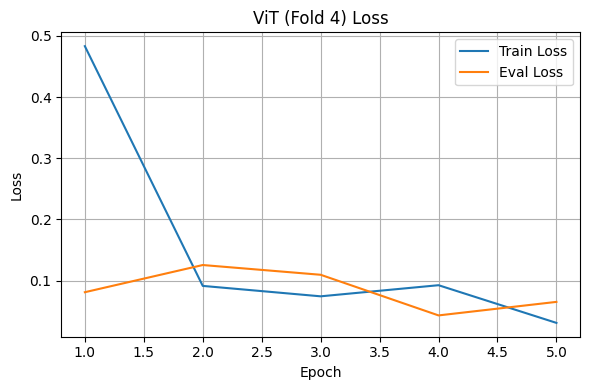

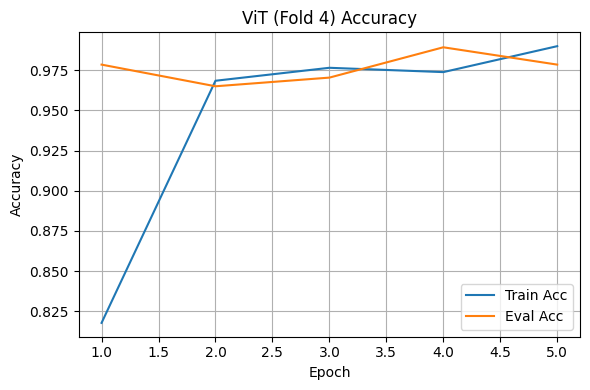

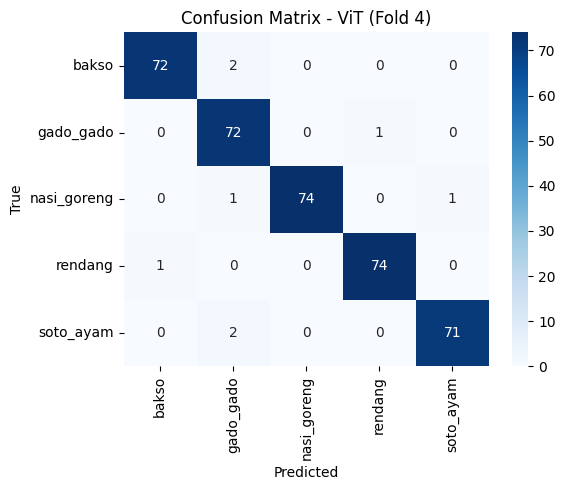

,precision,recall,f1-score,support
bakso,0.986301,0.972973,0.979592,74.000000
gado_gado,0.935065,0.986301,0.960000,73.000000
nasi_goreng,1.000000,0.973684,0.986667,76.000000
rendang,0.986667,0.986667,0.986667,75.000000
soto_ayam,0.986111,0.972603,0.979310,73.000000
accuracy,0.978437,0.978437,0.978437,0.978437
macro avg,0.978829,0.978446,0.978447,371.000000
weighted avg,0.979062,0.978437,0.978561,371.000000



=== DeiT | Best Fold: 4 | Val Acc: 0.9838 ===


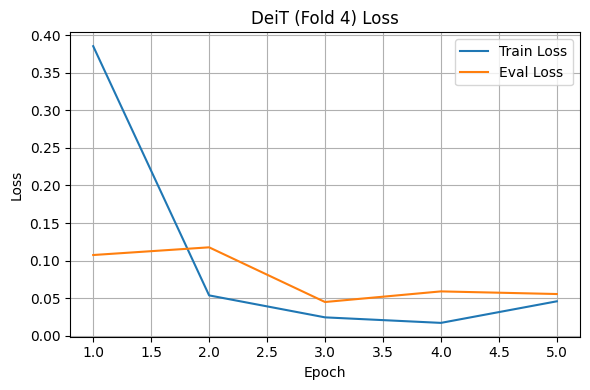

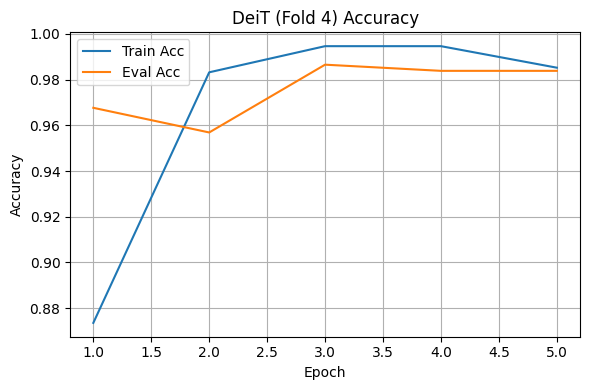

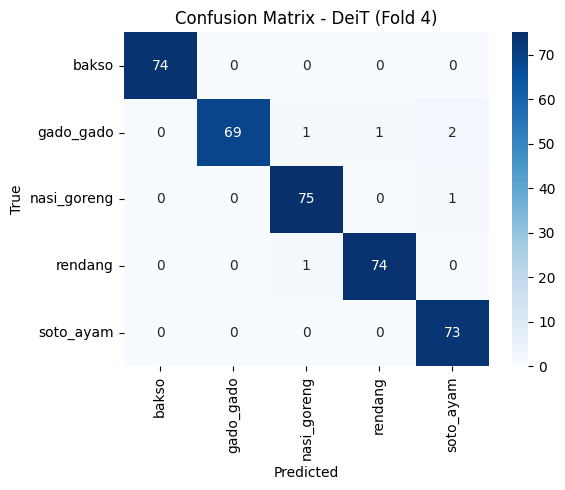

,precision,recall,f1-score,support
bakso,1.000000,1.000000,1.000000,74.000000
gado_gado,1.000000,0.945205,0.971831,73.000000
nasi_goreng,0.974026,0.986842,0.980392,76.000000
rendang,0.986667,0.986667,0.986667,75.000000
soto_ayam,0.960526,1.000000,0.979866,73.000000
accuracy,0.983827,0.983827,0.983827,0.983827
macro avg,0.984244,0.983743,0.983751,371.000000
weighted avg,0.984217,0.983827,0.983783,371.000000


In [11]:
for model_name in ["ViT", "DeiT"]:
    info = best_fold_info[model_name]
    print(f"\n=== {model_name} | Best Fold: {info['fold_idx']} | Val Acc: {info['best_acc']:.4f} ===")

    plot_history(info["history"], title_prefix=f"{model_name} (Fold {info['fold_idx']})")
    plot_confusion_matrix(info["cm"], classes, title=f"Confusion Matrix - {model_name} (Fold {info['fold_idx']})")
    print_classification_report(info["report"])


Ringkasan Fold


Merangkum seluruh hasil eksperimen ke dalam tabel:
   - Parameter model
   - Ukuran model (MB)
   - Validasi 5 fold (Akurasi, Precision, Recall, F1 Macro)
   - Waktu inferensi & throughput

Tabel ini digunakan sebagai bahan analisis untuk menentukan
model terbaik berdasarkan akurasi dan efisiensi.

In [12]:
summary_rows = []

for model_name in ["ViT", "DeiT"]:
    folds = results_cv[model_name]

    # parameter sama di semua fold → ambil dari fold pertama
    p = folds[0]["params"]

    val_accs = [f["val_acc"] for f in folds]
    macro_precisions = []
    macro_recalls = []
    macro_f1s = []
    avg_time_ms_list = []
    throughput_list = []

    for f in folds:
        rep = f["report"]["macro avg"]
        macro_precisions.append(rep["precision"])
        macro_recalls.append(rep["recall"])
        macro_f1s.append(rep["f1-score"])

        inf = f["infer"]
        avg_time_ms_list.append(inf["avg_time_ms_per_image"])
        throughput_list.append(inf["throughput_img_per_s"])

    summary_rows.append({
        "Model": model_name,
        "Total Params": p["total_params"],
        "Trainable Params": p["trainable_params"],
        "Non-trainable Params": p["non_trainable_params"],
        "Model Size (MB)": round(p["model_size_mb"], 2),
        "Val Acc (mean 5-fold)": round(np.mean(val_accs), 4),
        "Macro Precision (mean)": round(np.mean(macro_precisions), 4),
        "Macro Recall (mean)": round(np.mean(macro_recalls), 4),
        "Macro F1 (mean)": round(np.mean(macro_f1s), 4),
        "Infer Avg Time ms/img (mean)": round(np.mean(avg_time_ms_list), 4),
        "Infer Throughput img/s (mean)": round(np.mean(throughput_list), 2),
    })

df_summary = pd.DataFrame(summary_rows)
print("\n=== Ringkasan Perbandingan ViT vs DeiT (Rata-Rata 5 Fold) ===")
display(df_summary)


=== Ringkasan Perbandingan ViT vs DeiT (Rata-Rata 5 Fold) ===


,Model,Total Params,Trainable Params,Non-trainable Params,Model Size (MB),Val Acc (mean 5-fold),Macro Precision (mean),Macro Recall (mean),Macro F1 (mean),Infer Avg Time ms/img (mean),Infer Throughput img/s (mean)
0,ViT,85802501,85802501,0,327.31,0.9597,0.9621,0.9596,0.9598,10.2144,97.90
1,DeiT,21667589,21667589,0,82.66,0.9747,0.9756,0.9746,0.9747,2.8262,353.93
